In [19]:
from plotly.subplots import make_subplots
from os.path import *
from Bio import SeqIO
import pandas as pd
from subprocess import check_call
import json
from glob import glob
from tqdm import tqdm
import os
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")
os.chdir('/mnt/ivy/thliao/project/nif_jjtao/amplicons_study')

from scipy.stats import mannwhitneyu, ranksums
import plotly.figure_factory as ff
from plotly.figure_factory import create_distplot
import plotly.express as px
from plotly import graph_objects as go
import numpy as np
from scipy.stats import mannwhitneyu,ranksums
import itertools

pd.set_option('display.max_rows',1001)

t2color = {"Sym": "#f4a7a6",
           "Sym_Basal": "#f4a7a6",
           "FL": "#71dab8",
           "PB": "#60b0fd",
           "Cluster FL": "#71dab8",
           "Cluster PB": "#60b0fd",
          }
 

In [ ]:
import json
import json,re

def get_node_name_from_part(partial_text):
    splited_r = re.split("[,()]",partial_text)
    node_name = splited_r[-1]
        
        
    if "{" in node_name:
        return node_name.split('{')[0]
    return node_name

def parse_tree_with_edges(tree_with_edges):
    node_name2edge_num = {}
    colon_sep = tree_with_edges.split(':')
    for each_part in colon_sep:
        node_name = get_node_name_from_part(each_part)
        if node_name == ';':
            node_name = 'Root'
        if not "{" in each_part:
            node_name2edge_num[node_name] = 0
        else:
            edge_num = re.findall("\{([0-9]+)\}",each_part)
            edge_num = edge_num[0]
            node_name2edge_num[node_name] = int(edge_num)+1  # apart from 1
        
    removed_tree = re.sub("\{[0-9]+\}","",tree_with_edges)
    t = Tree(removed_tree,format=1)
    return t,node_name2edge_num



def parse_placement(placement):
    genome2edge = {}
    for d in placement:
        genome = d['n'][0]
        edge = d['p'][0][0]
        genome2edge[genome] = edge
    return genome2edge

def read_jplace(jplace_file):
    # the placements generated by apples aren't reliable
    obj = json.load(open(jplace_file))
    placement_actions = obj['placements']
    genome2edge = parse_placement(placement_actions)
    used_tree = obj["tree"]
    tree,node_name2edge_num = parse_tree_with_edges(used_tree)
    edge_num2node_name = {v:k for k,v in node_name2edge_num.items()}

    name2node = {n.name:n for n in tree.traverse()}
    genome2new_n = {}
    for genome,edge_num in genome2edge.items():
        node_name = edge_num2node_name[edge_num]

        node = name2node[node_name]
        node.add_sister(name=genome)
        genome2new_n[genome] = node
    return tree

def get_num(tree,nodes,node_name2edge_num):
    t = tree.get_common_ancestor(nodes)
    return [node_name2edge_num[ _.name] for _ in t.traverse()]

def classification_criteria(tree,node_name2edge_num):
    " for wang2020"
    cluster_PB = get_num(tree,['Bradyrhizobium_oligotrophicum_S58','Bradyrhizobium_sp_BTAi1'],node_name2edge_num)
    cluster_PB.append('Bradyrhizobium_sp_STM_3843')
    
    
    FL = get_num(tree,['Bradyrhizobium_iriomotense_SZCCT0346','Bradyrhizobium_sp_BK707'],node_name2edge_num)
    _tmp = get_num(tree,['Bradyrhizobium_sp_CCBAU_53426','Bradyrhizobium_sp_CCBAU_53424'],node_name2edge_num)
    for _ in _tmp:
        FL.remove(_)
#     FL.append(node_name2edge_num['Bradyrhizobium_AUGA_SZCCT0283'])  # FL near PB
    FL.extend(get_num(tree,['Bradyrhizobium_sp_S23321','Bradyrhizobium_sp_W'],node_name2edge_num))
    
    FL_in_Sym = []
    FL_in_Sym.append(node_name2edge_num['Bradyrhizobium_mercantei_SEMIA_6399'])
    FL_in_Sym.append(node_name2edge_num['Bradyrhizobium_yuanmingense_P10_130'])
    FL_in_Sym.append(node_name2edge_num['Bradyrhizobium_liaoningense_CCBAU_83689'])
    
    sym_basal = get_num(tree,['Bradyrhizobium_sp_Cp5_3','Bradyrhizobium_stylosanthis_BR_446'],node_name2edge_num)
    sym_basal.extend(_tmp)
    
    Sym_all = []
    Sym_all.extend(get_num(tree,['Bradyrhizobium_sp_WSM4349','Bradyrhizobium_canariense_UBMAN05'],node_name2edge_num))
    Sym_all.extend(get_num(tree,['Bradyrhizobium_sp_WSM2254','Bradyrhizobium_pachyrhizi_BR3262'],node_name2edge_num))
    
    for _ in FL_in_Sym:
        Sym_all.remove(_)
    
    criteria = {"PB":cluster_PB,
                "FL":FL, #+FL_in_Sym,
                "Sym_Basal":sym_basal,
                "Sym":Sym_all}
    return criteria

def get_classification(tree,node_name2edge_num,df):
    criteria = classification_criteria(tree,node_name2edge_num)
    
    seq2type = {}
    for type_name,edge_nums in criteria.items():
        sub_df = df.loc[df['edge_num'].isin(edge_nums)]
        names = list(sub_df['name'])
        seq2type.update({n:type_name for n in names})
    return seq2type

def get_closest_matches(tree,node_name2edge_num,df):
    edge_num2node_name = {v:k for k,v in node_name2edge_num.items()}
    seq2edge_num = dict(zip(df['name'],
                            [edge_num2node_name[_] for _ in df['edge_num']]))
    if not tree.name :
        tree.name = 'Root'
    name2node = {n.name:n for n in tree.traverse()}
    leafs = tree.get_leaf_names()
    zero_seq = [k for k,v in seq2edge_num.items() if v == '0']
    seq2edge_num = {k:v for k,v in seq2edge_num.items() if v!='0'}
    seq2closest_match = {k:v 
                         if v in leafs else name2node[v].get_closest_leaf()                    
                         for k,v in seq2edge_num.items()}
    return seq2closest_match


In [3]:

df2 = pd.read_excel('/mnt/ivy/thliao/project/nif_jjtao/amplicons_study/SraRunTable.xlsx')
df = pd.read_excel('/mnt/ivy/thliao/project/nif_jjtao/amplicons_study/nifH metagenome_filtered_16S.xlsx')

df2.loc[df2['Experiment'].isin(set(df['Experiment Accession']))]

removed_srr = {'SRP135966' : ['SRR6854367'],
               "ERP108575": ["ERR2560196"] }

run2info_df = df2.set_index('Run')
useful_columns = ['BioProject', 'BioSample', "Experiment",
                  'Library Name', "Organism", "Sample Name", "SRA Study",
                  "AvgSpotLen", "Bases", 'Collection_Date',
                  'BioSampleModel',
                  'geo_loc_name_country',
                  'geo_loc_name_country_continent',
                  'geo_loc_name', "Isolation_source", 'env_biome',
                  'env_feature',
                  'env_material',
                  ]



In [519]:
classified_dict = {}
for jplace in tqdm(glob(f"./phylogenetic_placement/wang2020/epa_o/*/epa_result.jplace")):
    srr_id = basename(dirname(jplace))
    cmd = f"{guppy_exe} to_csv {jplace} > {dirname(jplace)}/jplace.csv"
    if not exists(f"{dirname(jplace)}/jplace.csv"):
        check_call(cmd,shell=1)
    df = pd.read_csv(f"{dirname(jplace)}/jplace.csv")
    df = df.sort_values('like_weight_ratio',ascending=False).groupby('name').head(1)
    obj = json.load(open(jplace))
    used_tree = obj["tree"]
    tree,node_name2edge_num = parse_tree_with_edges(used_tree)
    seq2type_epa = get_classification(tree,node_name2edge_num,df)
    # use blast to filter
    #seq2type_epa = {k:v for k,v in seq2type_epa.items() if k in normal_seqs[srr_id]}
    
    classified_dict[srr_id] = seq2type_epa
    # read in dada2 profilling table
    infa = f"./{srr_id}/{srr_id}_repr_dada2.fa"
    name2len = {_.name: len(_.seq)
                for _ in SeqIO.parse(infa, 'fasta')}
    count_tab = f"./{srr_id}/{srr_id}_table_dada2.csv"
    count_df = pd.read_csv(count_tab, sep='\t', index_col=0)
    if count_df.index[0] in [_.split(';')[0] for _ in name2len]:
        count_df = count_df
    else:
        count_df = count_df.T
    srr2total = count_df.sum(0)
    ratio_df = count_df/count_df.sum(0) * 100
    sub_ratio_df = ratio_df.loc[ratio_df.index.isin(seq2type_epa), :]
    sub_ratio_df.loc[:, 'type'] = [seq2type_epa[s] for s in sub_ratio_df.index]
    
    type2ratio = sub_ratio_df.groupby('type').sum().T
    tmp_df = pd.DataFrame(columns= ['PB', 'FL', 'Sym_Basal', 'Sym'])
    tmp_df = tmp_df.reindex(type2ratio.index)
    for c in type2ratio.columns:
        tmp_df.loc[:, c] = list(type2ratio.loc[:, c])
    tmp_df = tmp_df.fillna(0)
    tmp_df.loc[:, 'total reads'] = srr2total
    
    _odir = f'./wang2020/epa_out/{srr_id}'
    if not exists(_odir):
        os.system(f'mkdir -p {_odir}')
    tmp_df.to_csv(
       f'{_odir}/type_count.csv', sep='\t', index=1)

100%|██████████| 130/130 [03:03<00:00,  1.41s/it]


In [5]:
all_dfs = []
for tab in glob(f'./wang2020/epa_out/*/type_count.csv'):
    _df = pd.read_csv(tab, sep='\t', index_col=0)
    _df.index = [_.split('_')[0] for _ in _df.index]
    all_dfs.append(_df)
_type_count_df = pd.concat(all_dfs, 0)
_type_count_df.columns = [_ + ' (%)'
                          for _ in _type_count_df.columns[:-1]] + ['total number of remained reads']
no_zero_sra = _type_count_df.index[_type_count_df.iloc[:, :-1].sum(1) != 0]
sub_run2info_df = run2info_df.reindex(columns=list(_type_count_df.columns) + list(run2info_df.columns))
sub_run2info_df.loc[_type_count_df.index,_type_count_df.columns] = _type_count_df
sub_srainfo_df = sub_run2info_df.reindex(no_zero_sra)

In [7]:
classified_critera = {"soil": ['rhizosphere metagenome',
                               'soil metagenome',
                               'mine tailings metagenome',
                               'mine metagenome',
                               'sediment metagenome',
                               'soil crust metagenome',
                               'compost metagenome',
                               'peat metagenome',
                               'oil sands metagenome'
                               ],
                      "marine": ['marine metagenome',
                                 'coral metagenome',
                                 'seawater metagenome',
                                 "marine sediment metagenome",
                                 'marine plankton metagenome',
                                 'beach sand metagenome',
                                 'coral reef metagenome',
                                 'mangrove metagenome'
                                 ],
                      "plant": ['plant metagenome',
                                'root metagenome',
                                'phyllosphere metagenome',
                                'Matricaria chamomilla',
                                'Solanum sp. 0048',
                                'Calendula officinalis'
                                ],
                      'others': ['bioreactor metagenome',
                                 'wastewater metagenome',
                                 'Bacteria',
                                 'metagenome',
                                 'synthetic metagenome',
                                 'biofilm metagenome',
                                 'sludge metagenome',
                                 'freshwater metagenome',
                                 'mollusc metagenome'
                                 ]}

classified_critera_rev = {v: k for k,
                          _l in classified_critera.items() for v in _l}
srr2env = {}
sra2env = {}
for srr, row in sub_srainfo_df.iterrows():
    srr2env[srr] = classified_critera_rev.get(row['Organism'])
    sra2env[row['SRA Study']] = classified_critera_rev.get(row['Organism'])


In [15]:
remained_columns = ['Relative ratio PB (%)', 'Relative ratio FL (%)',  'Relative ratio Sym (%)','Relative ratio SymBasal (%)',
                    'PB (%)', 'FL (%)',  'Sym (%)','Sym_Basal (%)',
                    "Total Number (read)",
                    "Environmental type","BioProject","BioSample","SRA Study",'Organism','Isolation_source',"lat_lon","Center Name",]

ssub_srainfo_df = sub_srainfo_df.reindex(
    columns=['PB (%)', 'FL (%)', 'Sym (%)','Sym_Basal (%)'])
ssub_srainfo_df = ssub_srainfo_df.div(ssub_srainfo_df.sum(1), 0) * 100

final_df = sub_srainfo_df.reindex(columns=remained_columns)
final_df.loc[:,"Environmental type"] = [srr2env[_] for _ in final_df.index]
final_df.loc[:,"Total Number (read)"] = sub_srainfo_df['total number of remained reads']

final_df.loc[:,"Relative ratio PB (%)"] = ssub_srainfo_df['PB (%)'].round(2)
final_df.loc[:,"Relative ratio FL (%)"] = ssub_srainfo_df['FL (%)'].round(2)
final_df.loc[:,"Relative ratio Sym (%)"] = ssub_srainfo_df['Sym (%)'].round(2)
final_df.loc[:,"Relative ratio SymBasal (%)"] = ssub_srainfo_df['Sym_Basal (%)'].round(2)
final_df.to_excel('./wang2020/epa_out/SraRun_metadata.xlsx',index=True,index_label='SRR ID')

In [11]:
ssub_srainfo_df = sub_srainfo_df.reindex(
    columns=['PB (%)', 'FL (%)', 'Sym (%)','Sym_Basal (%)'])
ssub_srainfo_df = ssub_srainfo_df.div(ssub_srainfo_df.sum(1), 0) * 100
new_df = []
for c in ['PB (%)', 'FL (%)', 'Sym (%)','Sym_Basal (%)' ]:
    _sub_df = pd.DataFrame(ssub_srainfo_df[c])
    _sub_df.columns = ['ratio']
    _sub_df.loc[:, 'nifH type'] = c.replace(' (%)', '')
    new_df.append(_sub_df)
new_df = pd.concat(new_df, axis=0)
new_df.loc[:, 'env type'] = [srr2env[_] for _ in new_df.index]
new_df.to_csv('./wang2020/fig5_data.csv',index=1,sep='\t')

# violin

In [12]:
def get_stars(p):
    if p <=0.05 and p >0.01:
        return '*'
    elif p<=0.01 and p >0.001:
        return '**'
    elif p<=0.001:
        return '***'
    return 'ns'

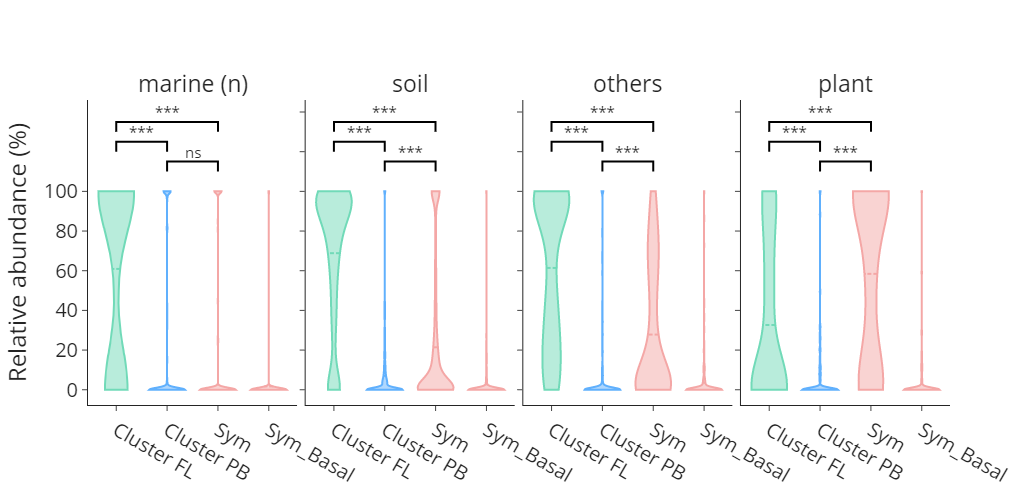

In [36]:
draw_df = new_df.replace('FL',"Cluster FL")
draw_df = draw_df.replace('PB',"Cluster PB")
draw_df = draw_df.replace('Sym_Basal',"Cluster SymBasal") 
draw_df = draw_df.fillna(0)
draw_df = draw_df.sort_values('nifH type')

fig = make_subplots(rows=1, 
                    cols=4,
                    shared_yaxes=True,
                    horizontal_spacing =0.01,
                   subplot_titles=['Marine', 'Soil',  'Plant','Others']
                   )
for i, env in enumerate(['marine', 'soil',  'plant','others']):
    traces = []
    sub_df = draw_df.loc[draw_df['env type']==env,:]
    for nifH_t in ['Cluster FL', 'Cluster PB', 'Sym','Cluster SymBasal'] :
        # manual adjust the x order of four types
        idxs = sub_df.groupby('nifH type').groups[nifH_t]
        _sub_df = sub_df.loc[sub_df['nifH type']==nifH_t,:]
        traces.append(go.Violin( x=[nifH_t]*len(idxs),
                                y=_sub_df.loc[idxs,'ratio'],
                                legendgroup=nifH_t,
                                name=nifH_t,
                                line_color=t2color[nifH_t],
                               #scalegroup=nifH_t,
                               spanmode='hard',
                                width=0.7,
                                #scalemode='width',
                                points=False,
                                meanline=dict(visible=True),
                               showlegend=False
        ))
    fig.add_traces(traces,1,i+1)
#fig.data[-1].showlegend= True

for idx,env in enumerate(['marine', 'soil',  'plant', 'others']):
    pos = [1.5,0.5,1,2,3,4,5]
    base_height = 110
    per_height = 5
    _count = 0
    for f1,f2 in [('Cluster PB', 'Sym'),
                  ('Cluster PB', 'Cluster FL'),
                  ('Cluster FL', 'Sym'),
                 ]:
        r1 = draw_df.loc[(draw_df['env type'] == env) &
                                         (draw_df['nifH type'] == f1), 'ratio']
        r2 = draw_df.loc[(draw_df['env type'] == env) &
                                         (draw_df['nifH type'] == f2), 'ratio']
        t = mannwhitneyu(r1,r2,#alternative='greater'
                        )
        p = t.pvalue
        
        
#         if p>=0.05:
#             base_height += 10
#             _count +=1
#             continue
        fig.add_traces(go.Scatter(x=[f1,f1,f2,f2],
                                  y=[base_height,
                                     base_height+per_height,
                                     base_height+per_height,
                                     base_height],
                                  showlegend=False,
                                  mode='lines',line=dict(color='#000000')) ,1,idx+1)
    #     fig.add_annotation(
    #         x=pos[_count],
    #         y=base_height+12,
    #         xanchor='center',
    #         xref=f'x{idx+1}',
    #         font=dict(size=15),
    #         showarrow=False,

    #         text="<Br> {:.2e} ".format(p),
    #     )
        fig.add_annotation(
                x=pos[_count],
                y=base_height+10,
                xanchor='center',
                xref=f'x{idx+1}',
                font=dict(size=15),
                showarrow=False,
                text=get_stars(p),
            )
            #print(get_stars(p),p,env,f1,f2)
        base_height += 10
        _count +=1
        
fig.layout.template = "simple_white"
fig.layout.width = 1400
fig.layout.height = 600
fig.layout.font.size = 17
fig.layout.font.family = 'Arial'
#fig.layout.yaxis.title = "Relative abundance of <Br> different types of nif clusters"
for _ in fig.layout.annotations[:4]:
    _['font']['size'] = 21
    _['font']['family'] = 'Arial'

fig.layout.yaxis.tickvals = [0,20,40,60,80,100]
fig.layout.yaxis.title = "Normalized abundance (%)"
fig.show()

# geological distribution

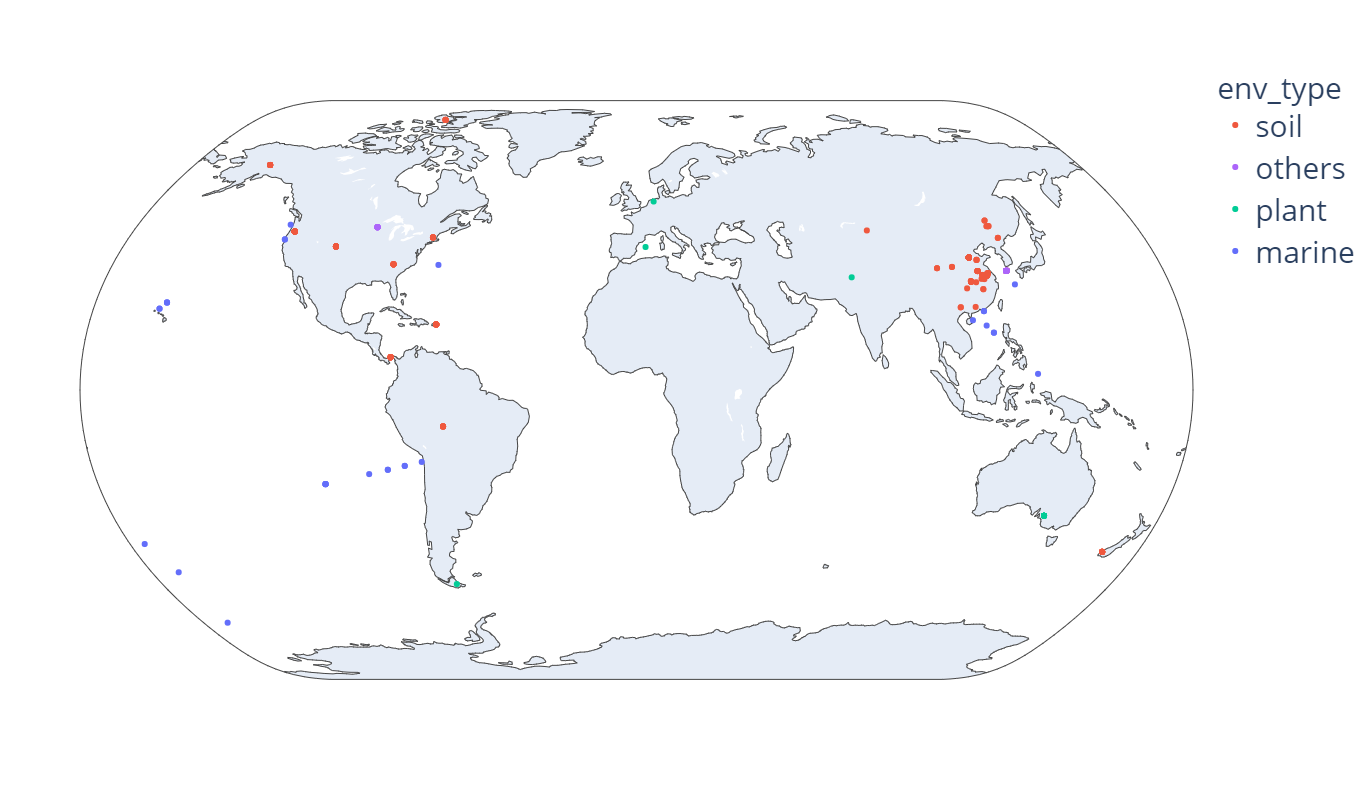

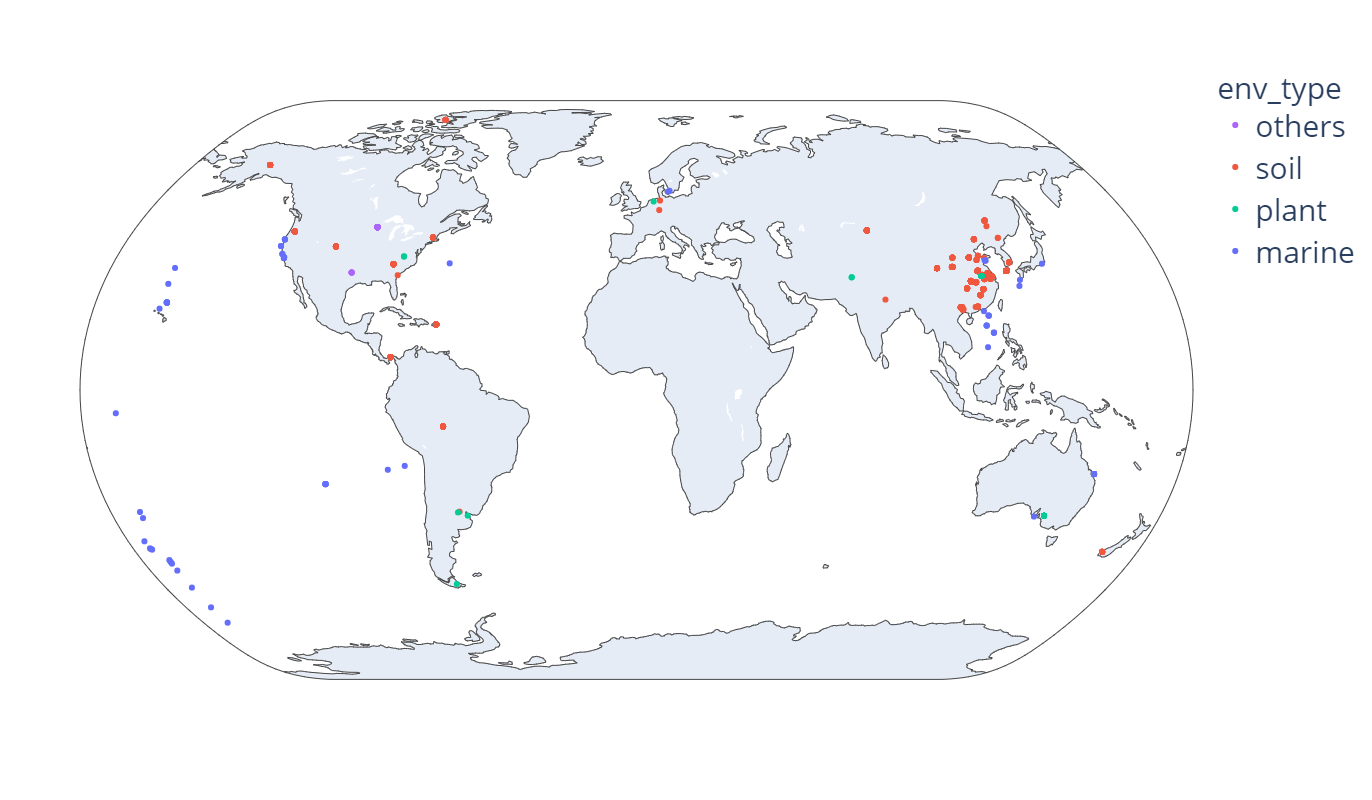

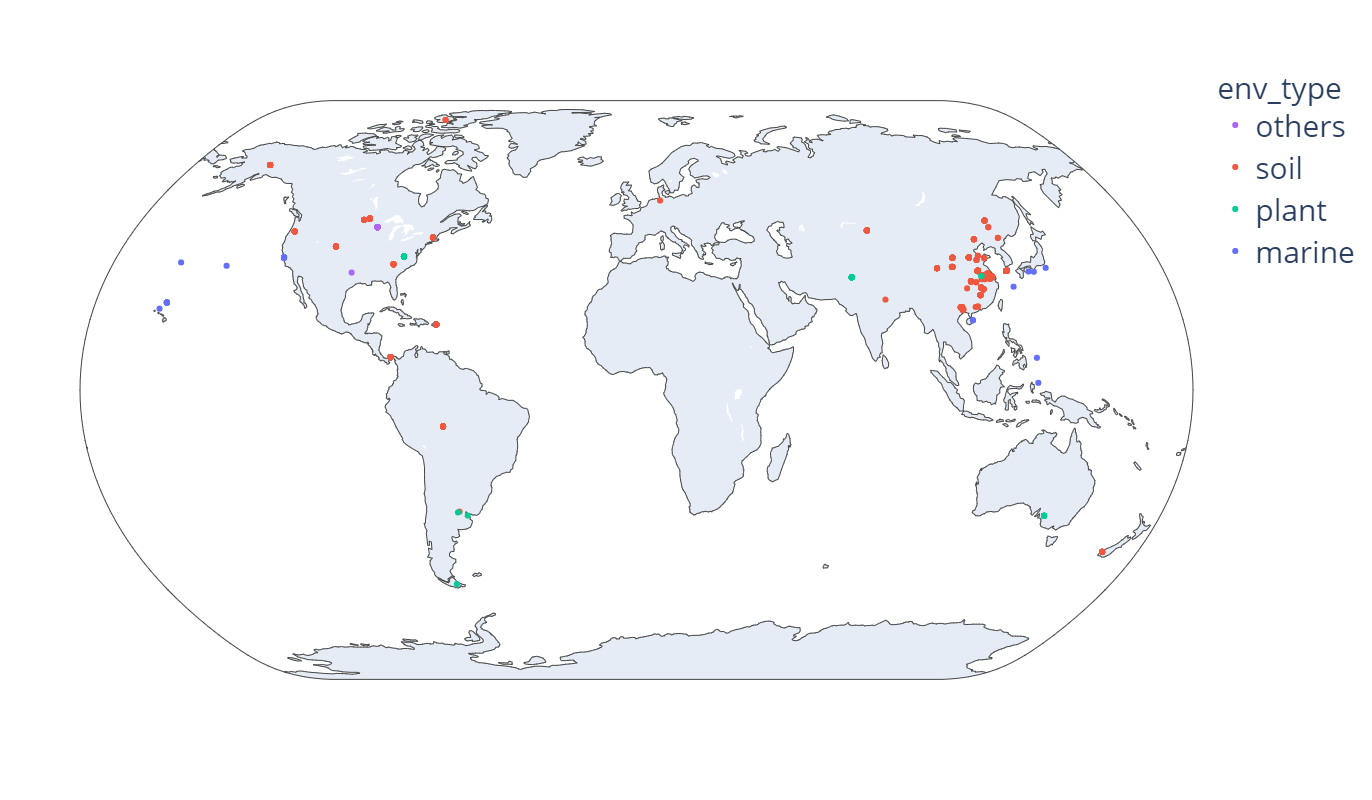

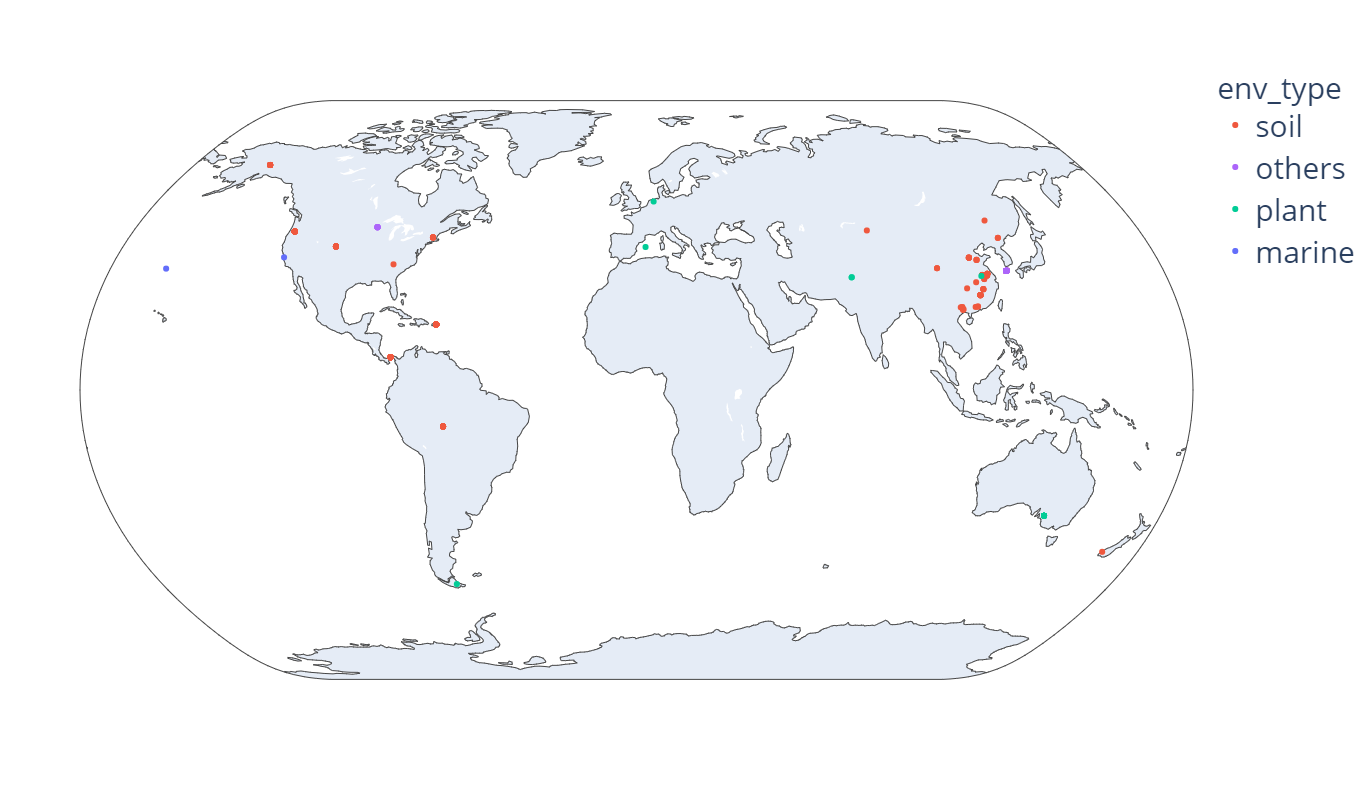

In [52]:

# draw global distribution
def convert_lat_lon(lat_lon):
    infos = lat_lon.split(' ')

    lat = float(infos[0]) if infos[1] == 'N' else -float(infos[0])
    lon = float(infos[2]) if infos[3] == 'E' else -float(infos[2])
    return lat, lon


printable_lat_lon_df = sub_srainfo_df[(~sub_srainfo_df['lat_lon'].isna()) & (~sub_srainfo_df['lat_lon'].isin(['Not Applicable',
                                                                                                              'missing',
                                                                                                              'not applicable',
                                                                                                              'not collected']))]
# for _ in printable_lat_lon_df['lat_lon']:
#     print(convert_lat_lon(_))

printable_lat_lon_df.loc[:, 'lat'] = [convert_lat_lon(
    _)[0] for _ in printable_lat_lon_df['lat_lon']]
printable_lat_lon_df.loc[:, 'lon'] = [convert_lat_lon(
    _)[1] for _ in printable_lat_lon_df['lat_lon']]

printable_lat_lon_df.loc[:, 'env_type'] = [srr2env[_]
                                           for _ in printable_lat_lon_df.index]


for t_nifH in ['PB (%)', 'FL (%)', 'Sym (%)','Sym_Basal (%)']:
    fig = px.scatter_geo(printable_lat_lon_df.loc[printable_lat_lon_df[t_nifH] != 0],
                         lat='lat',
                         lon='lon',
                         hover_data=['PB (%)',
                                     'FL (%)',
                                     'Sym_Basal (%)',
                                     'Sym (%)',
                                     'env_type'],
                         color='env_type',
                         color_discrete_map={'marine': '#636efa',
                                             'soil': '#ef583e',
                                             'others': '#ac65fa',
                                             'plant': '#01cc96'},
                         #size="FLnif (%)",
                         projection="natural earth")

    fig.layout.width = 1200
    fig.layout.height = 800
    fig.layout.font.size = 30
    fig.layout.title = f"{t_nifH.split(' ')[0]} nifH"
#     for _ in fig.data:
#         _['showlegend'] = False
    fig.layout.title = f""
    fig.show()
    #fig.write_image(f"./wang2020/{t_nifH.split(' ')[0]}nifH global.pdf")

# split violin plots (try)

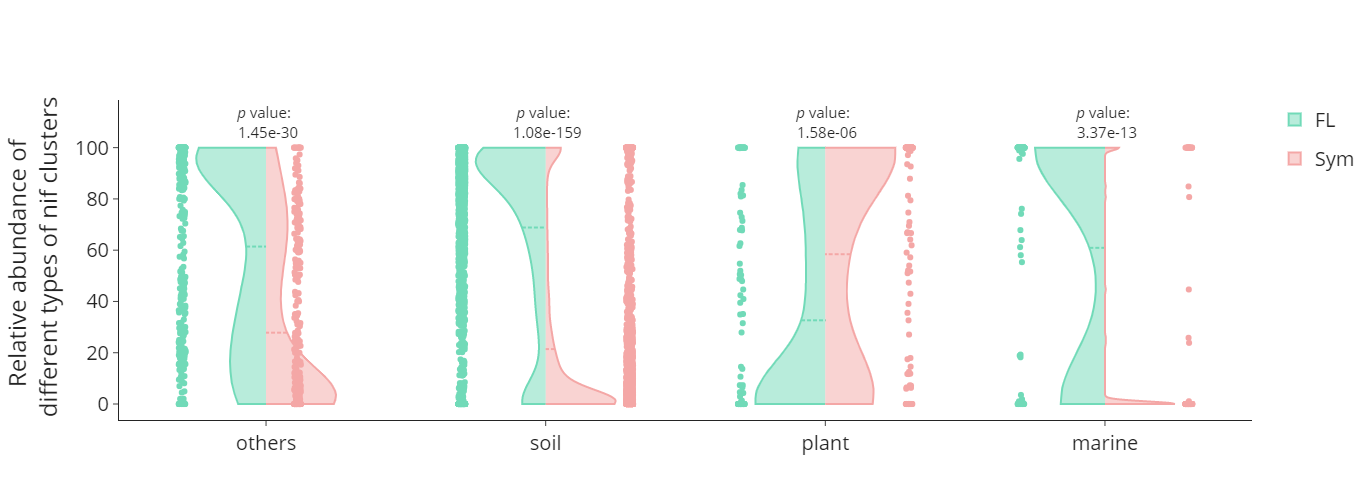

In [57]:
pointpos_male = [-1.2, -1.2, -1.2, -1.2]
pointpos_female = [0.45, 1.2, 1.2, 1.2]
show_legend = [True, False, False, False]

fig = go.Figure()
for i, env in enumerate(pd.unique(new_df['env type'])):
    fig.add_trace(go.Violin(x=new_df.loc[(new_df['env type'] == env) &
                                         (new_df['nifH type'] == 'FL'),
                                         'env type'],
                            y=new_df.loc[(new_df['env type'] == env) &
                                         (new_df['nifH type'] == 'FL'),
                                         'ratio'],
                            legendgroup='FL',
                            scalegroup='FL',
#                             bandwidth=1,
                            name='FL',
                            side='negative',
                            width=0.5,
                            # where to position points
                            pointpos=pointpos_male[i],
                            line_color=t2color['FL'],
                            showlegend=show_legend[i])
                  )
    fig.add_trace(go.Violin(x=new_df.loc[(new_df['env type'] == pd.unique(new_df['env type'])[i]) &
                                         (new_df['nifH type'] == 'Sym'), 'env type'],
                            y=new_df.loc[(new_df['env type'] == pd.unique(new_df['env type'])[i]) &
                                         (new_df['nifH type'] == 'Sym'), 'ratio'],
                            legendgroup='Sym',
#                             bandwidth=1,
                            scalegroup='Sym',
                            name='Sym',
                            side='positive',
                            width=0.5,
                            pointpos=pointpos_female[i],
                            line_color=t2color['Sym'],
                            showlegend=show_legend[i])
                  )

# update characteristics shared by all traces
fig.update_traces(meanline_visible=True,
                  #meanline_color='#000000',
                  spanmode='hard',
                  points='all',  # show all points
                  jitter=0.05,  # add some jitter on points for better visibility
                  #scalemode='width'
                  )  # scale violin plot area with total count
fig.update_layout(
    #title_text="Total bill distribution<br><i>scaled by number of bills per gender",
    violingap=0, violingroupgap=0, violinmode='overlay')
fig.layout.template = "simple_white"
fig.layout.width = 1200
fig.layout.height = 500
fig.layout.font.size = 20
fig.layout.yaxis.title = "Relative abundance of <Br> different types of nif clusters"


for env in pd.unique(new_df['env type']):
    f1='Sym'
    f2='FL'
    r1 = new_df.loc[(new_df['env type'] == env) &
                                     (new_df['nifH type'] == f1), 'ratio']
    r2 = new_df.loc[(new_df['env type'] == env) &
                                     (new_df['nifH type'] == f2), 'ratio']
    t = mannwhitneyu(r1,r2,#alternative='greater'
                    )
    p = t.pvalue
    fig.add_annotation(
        x=env,
        y=110,
        font=dict(size=15),
        showarrow=False,
        text="<i>p</i> value: <Br> {:.2e}".format(p),
    )

fig.show()

# distribution plots

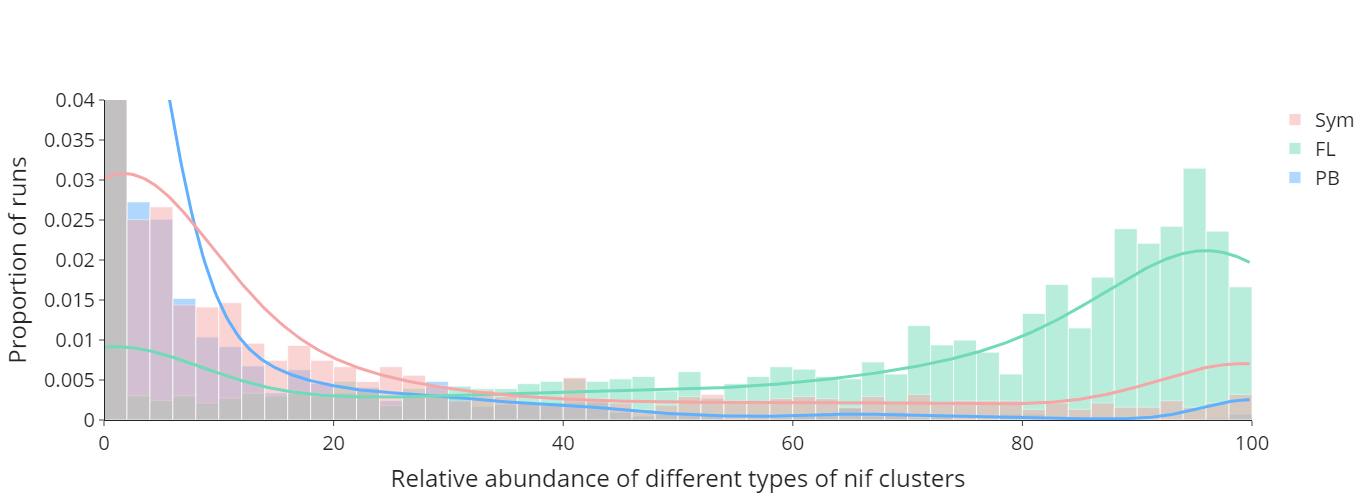

In [58]:
fig = px.histogram(new_df,
                   x='ratio',
                   color='nifH type',
                   color_discrete_map=t2color,
                   #barnorm='percent'
                   histnorm='percent'
                  )
# fig = go.Figure()
ts = [ 'PB', 'FL','Sym',]
fig = ff.create_distplot([list(new_df.loc[(new_df['nifH type'] == t),
                                           'ratio'])
                           for t in ts],
                          ts,
                          colors=[t2color[t] for t in ts],
                          #show_hist=False,#,showlegend=False
                          #curve_type='normal',
                          #histnorm='percent',
                              show_hist=True,
                          show_curve=True,
                          show_rug=False,
                          #showlegend=False,
                               #opacity=0.5
                         bin_size=2,
                         )
#fig.add_traces(_fig.data)
for _ in fig.data:
    _['opacity'] = 0.5
for _ in fig.data[-3:]:
    _.line.width=3
    _.opacity = 1
   # _.line.opacity=1
fig.update_layout(barmode='overlay')
fig.layout.template = "simple_white"
fig.layout.width = 1200
fig.layout.height = 500
fig.layout.yaxis.range=[0,0.04]
fig.layout.font.size = 20
fig.layout.xaxis.title = "Relative abundance of different types of nif clusters"
fig.layout.yaxis.title = 'Proportion of runs'
fig.show()
